<a href="https://colab.research.google.com/github/bansal247/bansal247/blob/main/Instacart_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the data

## Fetching the data

First, you need to upload kaggle.json

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c instacart-market-basket-analysis

In [ ]:
!unzip "/content/aisles.csv.zip" -d "/content/datasets/"
!unzip "/content/departments.csv.zip" -d "/content/datasets/"
!unzip "/content/order_products__prior.csv.zip" -d "/content/datasets/"
!unzip "/content/order_products__train.csv.zip" -d "/content/datasets/"
!unzip "/content/orders.csv.zip" -d "/content/datasets/"
!unzip "/content/products.csv.zip" -d "/content/datasets/"

## Let's have a look on data

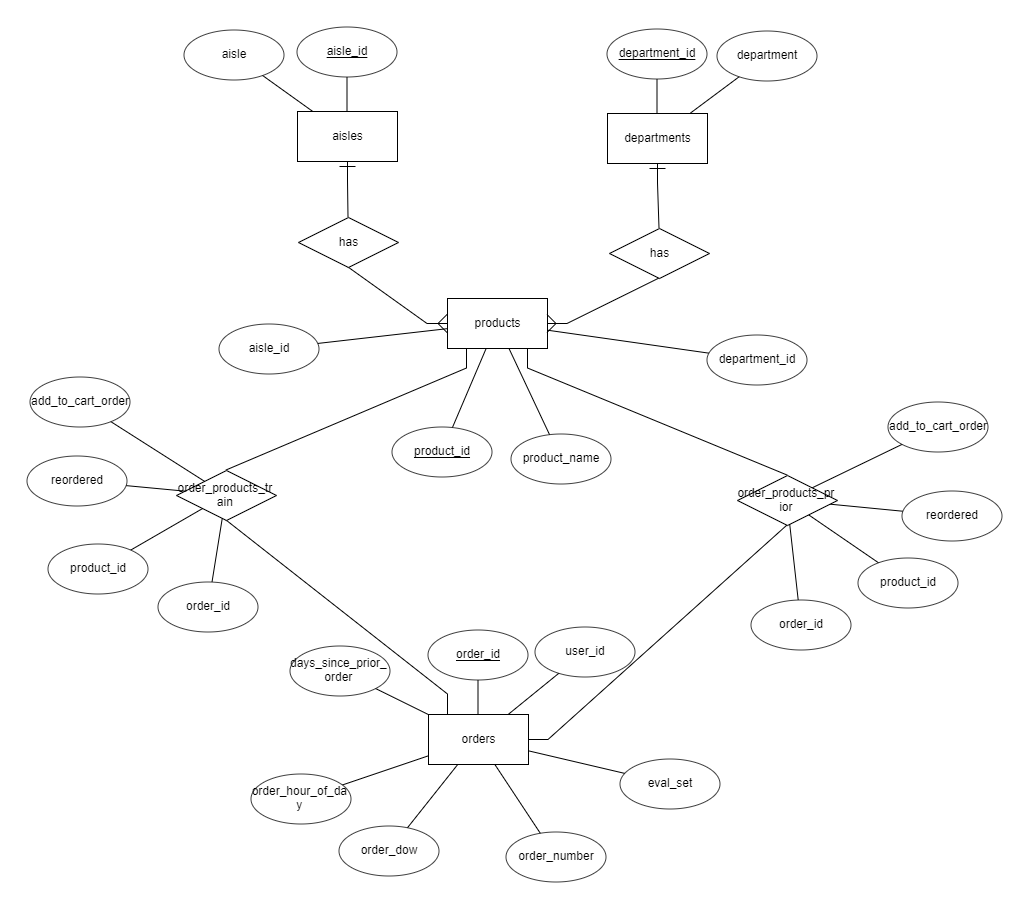

In [7]:
from IPython.display import Image
Image(filename='/content/Images/er_diagram.png')

1. From above ER diagram we can easily relate entities.

2. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

3. orders.csv tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

4. Then we have products with their aisles and departments

## Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
aisles = pd.read_csv("/content/datasets/aisles.csv")
departments = pd.read_csv("/content/datasets/departments.csv")
order_products__prior = pd.read_csv("/content/datasets/order_products__prior.csv")
order_products__train = pd.read_csv("/content/datasets/order_products__train.csv")
orders = pd.read_csv("/content/datasets/orders.csv")
products = pd.read_csv("/content/datasets/products.csv")

# Exploratory Data Analysis

## Let's explore orders first

In [12]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [13]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Here we have some days_since_prior_order as null values, since we can have orders which are ordered only once.

For now I am leaving it null.

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


Let's have a look on eval_set since it is an object

In [16]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

Since, it has three categories, change the type to categoru

In [17]:
orders.eval_set = orders.eval_set.astype('category')

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
dtypes: category(1), float64(1), int64(5)
memory usage: 159.9 MB


Let's have a look on distribution of days_since_prior_order

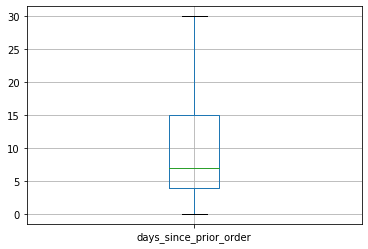

In [25]:
orders.boxplot(column=['days_since_prior_order'])
plt.show()

From the boxplot we can see there are **no outliers** and **interquartile range is from 4 to 15 (roughly)** so I can use mean and median both for filling null values but by looking at the domain **I choose median to fill null values**.

In [74]:
orders.days_since_prior_order = orders.days_since_prior_order.fillna(orders.days_since_prior_order.median())

In [75]:
orders.isna().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

Now we have clean data.

Let's get some inferences.

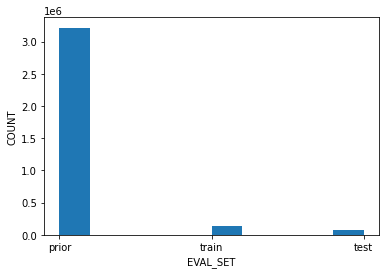

In [39]:
plt.hist(x=orders.eval_set)
plt.xlabel("EVAL_SET")
plt.ylabel("COUNT")
plt.show()

Since test set is required for evaluation we seperate the test data

In [43]:
orders_test = orders[orders['eval_set']=='test']
orders_test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [44]:
orders_test.shape

(75000, 7)

In [48]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,7.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Now let's see orders count distribution

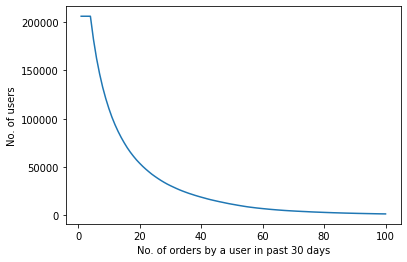

In [76]:
plt.plot(orders.order_number.value_counts())
plt.xlabel("No. of orders by a user in past 30 days")
plt.ylabel("No. of users")
plt.show()

In [77]:
orders.order_number.value_counts()[orders.order_number.value_counts().index >=50].sum()/orders.order_number.value_counts().sum()

0.06674319214120207

From here we can see that only 6.7% users have ordered atleast 50 times in past 30 days

Let's analyse order day of week 

In [80]:
orders.order_dow.value_counts()

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

Since day 0 and 1 have highest orders this means that they are saturday and sunday so let's map accordingly

In [78]:
orders['weekdays'] = orders.order_dow.map({
    0:'Saturday',
    1:'Sunday',
    2:'Monday',
    3:'Tuesday',
    4:'Wednesday',
    5:'Thursday',
    6:'Friday'
}).astype(str)

In [79]:
orders.weekdays.value_counts()

Saturday     600905
Sunday       587478
Monday       467260
Thursday     453368
Friday       448761
Tuesday      436972
Wednesday    426339
Name: weekdays, dtype: int64

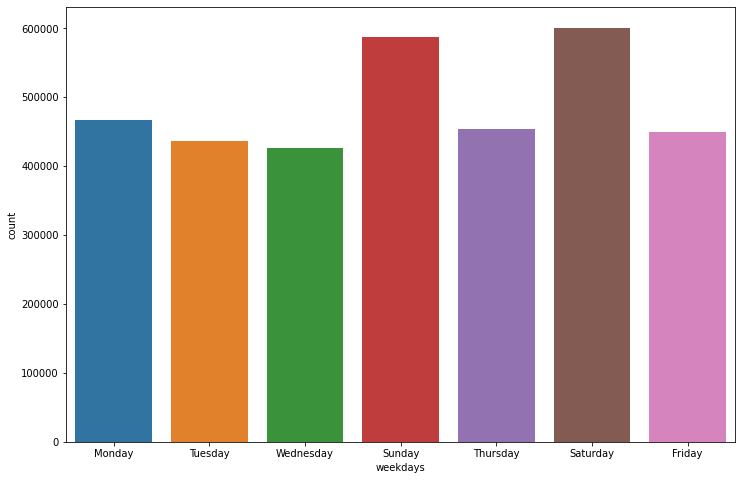

In [83]:
plt.figure(figsize=(12,8))
sns.countplot(x="weekdays",data=orders)
plt.show()

Let's analyse hour of day

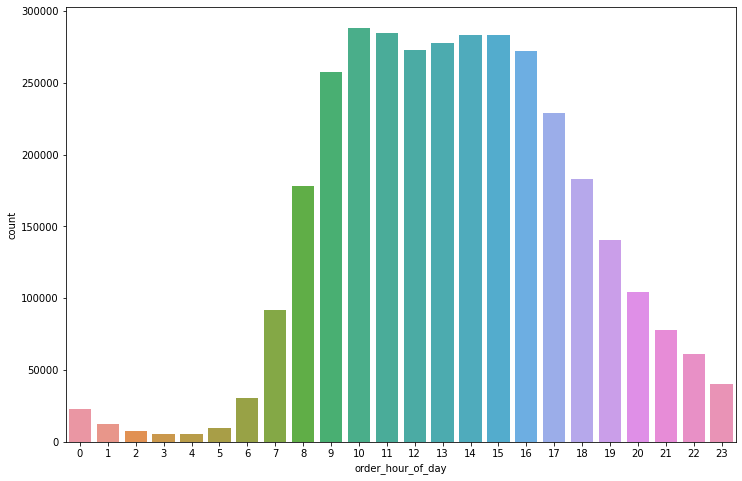

In [84]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day",data=orders)
plt.show()

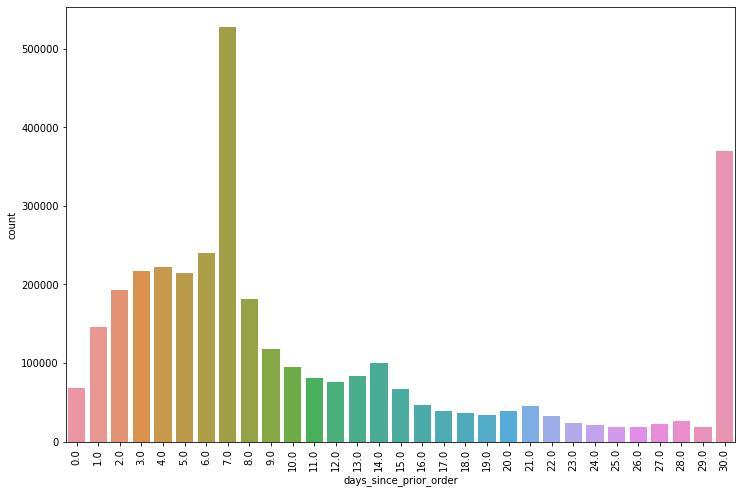

In [91]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order",data=orders)
plt.xticks(rotation='vertical')
plt.show()

In [118]:
grouped_orders = pd.DataFrame(orders.groupby(by=["weekdays","order_hour_of_day"])["order_id"].nunique().reset_index())

In [120]:
grouped_orders = grouped_orders.pivot(index='weekdays', columns='order_hour_of_day', values='order_id')

In [121]:
grouped_orders.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
weekdays,,,,,,,,,,,,,,,,,,,,,,,,
Friday,3306,1919,1214,863,802,1136,3243,11319,22960,30839,35665,36994,37121,37564,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087
Monday,3059,1572,943,719,744,1399,4758,13245,24635,36314,39230,38128,35780,36650,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
Saturday,3936,2398,1409,963,813,1168,3329,12410,28108,40798,48465,51035,51443,53849,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
Sunday,3674,1830,1105,748,809,1607,5370,16571,34116,51908,55671,51584,47079,46728,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
Thursday,3189,1672,1016,841,910,1574,4866,13434,24015,34232,38313,37915,35714,36296,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265


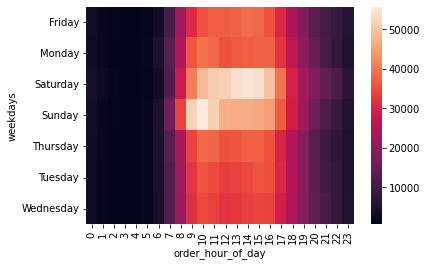

In [122]:
sns.heatmap(grouped_orders)

From here we can infer that on saturdays and sundays from 8 am to 4 pm highest number of orders are made